# 1. Set up

In [1]:
# Core libraries
import os
import random
from collections import defaultdict

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset, Dataset

# torchvision
import torchvision
from torchvision import datasets, transforms, models
from torchvision.transforms import InterpolationMode
from torchvision.datasets import ImageFolder

# torchsummary
from torchsummary import summary

# Utilities
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 2. Data loading and Preprocessing

In [2]:
##### This cell is for raw WikiArt dataset . If data are loaded by CSV file, run the next cell


# # 1. Load original WikiArt dataset
# dataset = ImageFolder("/kaggle/input/wikiart", transform=transform)

# # 2. Group indices by class
# class_to_indices = defaultdict(list)
# for idx, (_, label) in enumerate(dataset.samples):
#     class_to_indices[label].append(idx)

# # 3. Filter classes with ≥4000 images
# filtered_indices = []
# label_map = {}  # mapping from old → new labels
# new_label = 0

# for label, indices in class_to_indices.items():
#     if len(indices) >= 4000:
#         selected = random.sample(indices, 4000)
#         filtered_indices.extend(selected)
#         label_map[label] = new_label
#         new_label += 1

# # 4. Patch dataset.labels to new labels
# filtered_samples = [dataset.samples[i] for i in filtered_indices]
# patched_samples = [(path, label_map[label]) for path, label in filtered_samples]

# import pandas as pd

# # Create DataFrame from (path, new_label) tuples
# df = pd.DataFrame(patched_samples, columns=["image_path", "label"])

# # Save to a location Kaggle allows (usually /kaggle/working/)
# csv_path = "/kaggle/working/sampled_wikiart.csv"
# df.to_csv(csv_path, index=False)

# print(f"Saved sampled dataset to {csv_path}")

In [3]:
import os, shutil, random
from tqdm import tqdm
from pathlib import Path

original_data_dir = Path('/kaggle/input/wikiart')
base_dir = Path('/kaggle/working/dataset_split')
train_ratio, val_ratio = 0.8, 0.1
MAX_IMAGES_PER_CLASS = 1000
selected_classes = [
    'Abstract_Expressionism','Color_Field_Painting','Cubism',
    'Early_Renaissance','High_Renaissance','Mannerism_Late_Renaissance',
    'Minimalism','Naive_Art_Primitivism','Pop_Art','Rococo'
]

# reproducibility
random.seed(42)

# clean & make dirs
if base_dir.exists():
    shutil.rmtree(base_dir)
for split in ['train','val','test']:
    (base_dir/split).mkdir(parents=True, exist_ok=True)

final_counts = {}

for class_name in tqdm(selected_classes, desc="Processing classes"):
    src_folder = original_data_dir/class_name
    if not src_folder.exists():
        print(f" Missing class folder: {src_folder}")
        continue

    # list images
    exts = {'.jpg','.jpeg','.png','.bmp','.webp'}
    all_images = [p for p in src_folder.iterdir() if p.suffix.lower() in exts]
    if not all_images:
        print(f" No images for {class_name}")
        continue

    random.shuffle(all_images)
    images = all_images[:MAX_IMAGES_PER_CLASS]
    n = len(images)

    # rounded split (close to 80/10/10) with small-class safety
    n_train = int(round(train_ratio * n))
    n_val   = int(round(val_ratio * n))
    n_test  = n - n_train - n_val
    # ensure no negative / empty splits when n is small
    if n >= 3:
        if n_test < 1: 
            n_test = 1
            n_train = max(1, n_train - 1)
        if n_val < 1:
            n_val = 1
            if n_train > 1: n_train -= 1
            else: n_test = max(1, n_test - 1)
    else:
        # e.g., n==1 or 2 → just put all into train/test
        n_train = max(1, n-1)
        n_val = 0
        n_test = n - n_train

    train_imgs = images[:n_train]
    val_imgs   = images[n_train:n_train+n_val]
    test_imgs  = images[n_train+n_val:]

    # make class dirs
    for split in ['train','val','test']:
        (base_dir/split/class_name).mkdir(parents=True, exist_ok=True)

    # copy or symlink (change to os.symlink for speed on Kaggle)
    def place(imgs, split):
        for p in imgs:
            dst = base_dir/split/class_name/p.name
            shutil.copy(p, dst)  # or: os.symlink(p, dst)

    place(train_imgs, 'train')
    place(val_imgs,   'val')
    place(test_imgs,  'test')

    final_counts[class_name] = {
        'train': len(train_imgs), 'val': len(val_imgs), 'test': len(test_imgs)
    }

# summary
print("\n--- Dataset Splitting Complete ---")
tot_train = tot_val = tot_test = 0
for cls, c in final_counts.items():
    t = c['train']+c['val']+c['test']
    tot_train += c['train']; tot_val += c['val']; tot_test += c['test']
    print(f"{cls:28s}  train={c['train']:4d}  val={c['val']:4d}  test={c['test']:4d}  total={t:4d}")
print(f"\nTotals: train={tot_train}  val={tot_val}  test={tot_test}  (all={tot_train+tot_val+tot_test})")

Processing classes: 100%|██████████| 10/10 [01:39<00:00,  9.97s/it]


--- Dataset Splitting Complete ---
Abstract_Expressionism        train= 800  val= 100  test= 100  total=1000
Color_Field_Painting          train= 800  val= 100  test= 100  total=1000
Cubism                        train= 800  val= 100  test= 100  total=1000
Early_Renaissance             train= 800  val= 100  test= 100  total=1000
High_Renaissance              train= 800  val= 100  test= 100  total=1000
Mannerism_Late_Renaissance    train= 800  val= 100  test= 100  total=1000
Minimalism                    train= 800  val= 100  test= 100  total=1000
Naive_Art_Primitivism         train= 800  val= 100  test= 100  total=1000
Pop_Art                       train= 800  val= 100  test= 100  total=1000
Rococo                        train= 800  val= 100  test= 100  total=1000

Totals: train=8000  val=1000  test=1000  (all=10000)


In [4]:
# --- Reproducibility ---
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# --- Paths & Settings ---
base_dir = Path('/kaggle/working/dataset_split')  # from your previous step
batch_size = 16
num_workers = 2

# Choose input size for your backbone

IMG_SIZE = 224
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

# ---- Train transforms (balanced + faster CPU) ----
train_tf = transforms.Compose([
    transforms.Resize(int(IMG_SIZE * 1.15),
                      interpolation=InterpolationMode.BILINEAR,
                      antialias=True),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0),
                                 interpolation=InterpolationMode.BILINEAR,
                                 antialias=True),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.10),
                             ratio=(0.3, 3.3), value='random')
])

# ---- Val/Test transforms (deterministic) ----
eval_tf = transforms.Compose([
    transforms.Resize(int(IMG_SIZE * 1.15),
                      interpolation=InterpolationMode.BILINEAR,
                      antialias=True),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])
# --- Datasets ---
train_ds = datasets.ImageFolder(base_dir / 'train', transform=train_tf)
val_ds   = datasets.ImageFolder(base_dir / 'val',   transform=eval_tf)
test_ds  = datasets.ImageFolder(base_dir / 'test',  transform=eval_tf)

# --- Worker seeding (for transforms with randomness) ---
def worker_init_fn(worker_id):
    seed = SEED + worker_id
    np.random.seed(seed)
    random.seed(seed)

# --- DataLoaders ---
train_loader = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True, drop_last=True,
    num_workers=num_workers, pin_memory=True, persistent_workers=num_workers > 0,
    worker_init_fn=worker_init_fn,
)

val_loader = DataLoader(
    val_ds, batch_size=batch_size, shuffle=False,
    num_workers=num_workers, pin_memory=True, persistent_workers=num_workers > 0,
)

test_loader = DataLoader(
    test_ds, batch_size=batch_size, shuffle=False,
    num_workers=num_workers, pin_memory=True, persistent_workers=num_workers > 0,
)

# --- Quick sanity check ---
print(f"Classes ({len(train_ds.classes)}):", train_ds.classes)
print("Train/Val/Test sizes:", len(train_ds), len(val_ds), len(test_ds))
imgs, labels = next(iter(train_loader))
print("Batch shape:", imgs.shape, "dtype:", imgs.dtype, "labels dtype:", labels.dtype)

Classes (10): ['Abstract_Expressionism', 'Color_Field_Painting', 'Cubism', 'Early_Renaissance', 'High_Renaissance', 'Mannerism_Late_Renaissance', 'Minimalism', 'Naive_Art_Primitivism', 'Pop_Art', 'Rococo']
Train/Val/Test sizes: 8000 1000 1000
Batch shape: torch.Size([16, 3, 224, 224]) dtype: torch.float32 labels dtype: torch.int64


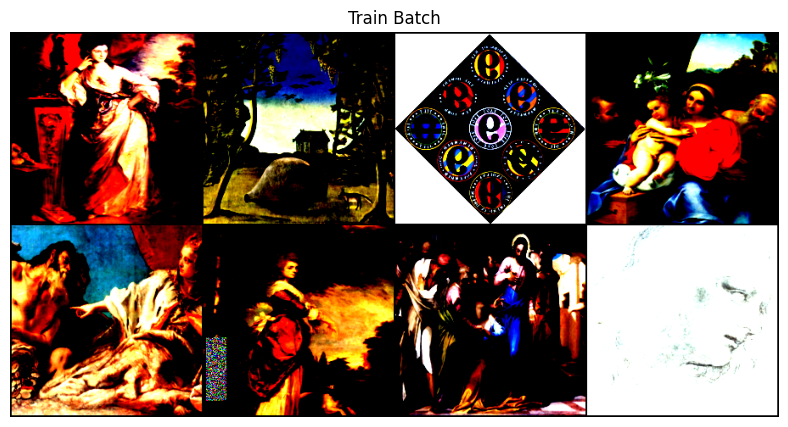

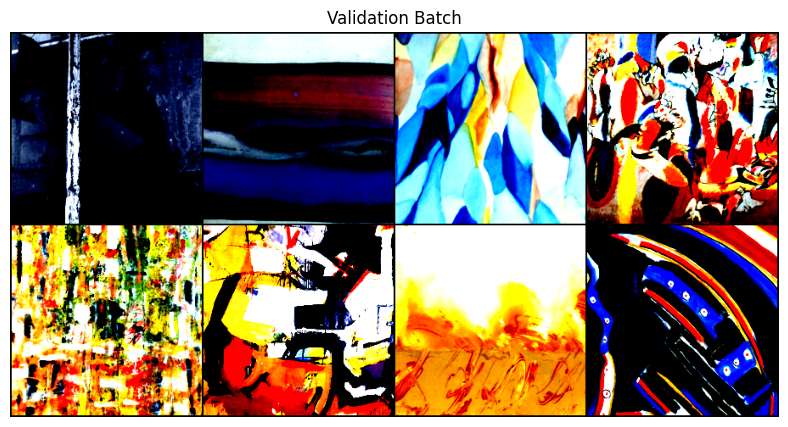

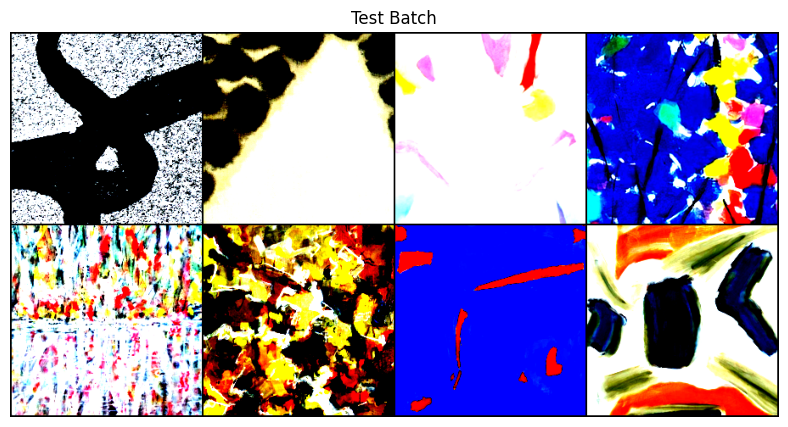

In [5]:

import matplotlib.pyplot as plt

def show_batch(loader, title):
    images, labels = next(iter(loader))
    grid = torchvision.utils.make_grid(images[:8], nrow=4)
    plt.figure(figsize=(10, 5))
    plt.imshow(grid.permute(1, 2, 0).numpy())
    plt.title(title)
    plt.axis("off")
    plt.show()

show_batch(train_loader, "Train Batch")
show_batch(val_loader, "Validation Batch")
show_batch(test_loader, "Test Batch")

# 3. Model, Criterion and Optimizer selection

In [6]:
num_classes = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Model (ViT-B/16 expects 224x224) ---
weights = models.ViT_B_16_Weights.IMAGENET1K_V1
model = models.vit_b_16(weights=weights)

# ViT hidden dim = 768; replace the head (keeps LayerNorm before head)
hidden = model.heads.head.in_features  # 768 for ViT-B/16
model.heads = nn.Sequential(
    nn.LayerNorm(hidden),

    nn.Linear(hidden, 1024, bias=False),
    nn.GELU(),
    nn.Dropout(0.30),
    nn.LayerNorm(1024),

    nn.Linear(1024, 512, bias=False),
    nn.GELU(),
    nn.Dropout(0.20),
    nn.LayerNorm(512),

    nn.Linear(512, 256, bias=False),
    nn.GELU(),
    nn.Dropout(0.20),

    nn.Linear(256, num_classes)  # raw logits
)

model = model.to(device)

# --- Param groups: head (heads.*) vs backbone; no WD for norm/bias/pos_embed/cls_token ---
def is_no_wd(name: str):
    n = name.lower()
    return (
        n.endswith(".bias") or
        "norm" in n or "bn" in n or
        "pos_embed" in n or "pos_embedding" in n or
        "cls_token" in n
    )

head_wd, head_nwd, back_wd, back_nwd = [], [], [], []
for n, p in model.named_parameters():
    if not p.requires_grad:
        continue
    is_head = n.startswith("heads")
    if is_no_wd(n):
        (head_nwd if is_head else back_nwd).append(p)
    else:
        (head_wd if is_head else back_wd).append(p)

param_groups = [
    {"params": head_wd,  "lr": 1e-3, "weight_decay": 5e-2},
    {"params": head_nwd, "lr": 1e-3, "weight_decay": 0.0},
    {"params": back_wd,  "lr": 5e-5, "weight_decay": 5e-2},
    {"params": back_nwd, "lr": 5e-5, "weight_decay": 0.0},
]

optimizer = optim.AdamW(param_groups)
EPOCHS = 40
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
scaler = torch.cuda.amp.GradScaler(enabled=device.type == "cuda")
CLIP_NORM = 1.0

print("\nModel Summary (ViT-B/16):")
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters:     {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(model)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 186MB/s]  



Model Summary (ViT-B/16):
Total parameters:     87,247,626
Trainable parameters: 87,247,626
VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): Encode

/tmp/ipykernel_36/2594276065.py:64: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=device.type == "cuda")


# 4. Training Loop and callback

In [7]:
import torch
from torch import nn
from tqdm import tqdm
from typing import List, Dict, Any

# =======================
# Callbacks
# =======================
class Callback:
    def on_train_start(self): pass
    def on_train_end(self): pass
    def on_epoch_start(self, epoch, logs=None): pass
    def on_epoch_end(self, epoch, logs=None): pass

class ModelCheckpoint(Callback):
    def __init__(self, filepath: str, monitor: str = "val_acc", mode: str = "max"):
        self.filepath = filepath
        self.monitor = monitor
        self.mode = mode
        self.best = float("-inf") if mode == "max" else float("inf")

    def on_epoch_end(self, epoch, logs=None):
        value = logs.get(self.monitor, None)
        if value is None:
            return
        improved = (value > self.best) if self.mode == "max" else (value < self.best)
        if improved:
            self.best = value
            torch.save(logs["model"].state_dict(), self.filepath)
            tqdm.write(f"✅ Model improved ({self.monitor}={value:.4f}). Saved to {self.filepath}")

class EarlyStopping(Callback):
    def __init__(self, patience: int = 5, monitor: str = "val_acc", mode: str = "max"):
        self.patience = patience
        self.monitor = monitor
        self.mode = mode
        self.best = float("-inf") if mode == "max" else float("inf")
        self.counter = 0
        self.early_stop = False

    def on_epoch_end(self, epoch, logs=None):
        value = logs.get(self.monitor, None)
        if value is None:
            return
        improved = (value > self.best) if self.mode == "max" else (value < self.best)
        if improved:
            self.best = value
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                tqdm.write("⏹️ Early stopping triggered.")
                self.early_stop = True

# =======================
# Eval helper
# =======================
@torch.no_grad()
def evaluate(model: nn.Module, loader, criterion: nn.Module, device: torch.device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    for images, labels in loader:
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    val_loss = total_loss / max(total, 1)
    val_acc = correct / max(total, 1)
    return val_loss, val_acc

# =======================
# Fit loop (pretty tqdm)
# =======================
def fit(
    model: nn.Module,
    train_loader,
    val_loader,
    optimizer: torch.optim.Optimizer,
    scheduler,                # can be None, ReduceLROnPlateau, or per-epoch scheduler
    criterion: nn.Module,
    device: torch.device,
    epochs: int = 40,
    callbacks: List[Callback] = None,
    use_amp: bool = True,
    clip_grad_norm: float = 0.0,
) -> Dict[str, Any]:

    callbacks = callbacks or []
    scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and device.type == "cuda"))

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for cb in callbacks:
        cb.on_train_start()

    for epoch in range(1, epochs + 1):
        # header line (avoids the outer 0/40 confusion)
        tqdm.write(f"\nEpoch {epoch}/{epochs}")

        for cb in callbacks:
            cb.on_epoch_start(epoch, logs=None)

        # ---------- TRAIN ----------
        model.train()
        running_loss = 0.0
        running_correct = 0
        seen = 0

        batch_bar = tqdm(
            train_loader, desc="Train", leave=False, dynamic_ncols=True
        )

        for images, labels in batch_bar:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)

            if scaler.is_enabled():
                with torch.cuda.amp.autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                scaler.scale(loss).backward()
                if clip_grad_norm > 0:
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad_norm)
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                if clip_grad_norm > 0:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad_norm)
                optimizer.step()

            # accumulators
            bs = labels.size(0)
            running_loss += loss.item() * bs
            preds = outputs.argmax(1)
            running_correct += (preds == labels).sum().item()
            seen += bs

            batch_bar.set_postfix(
                loss=f"{running_loss/seen:.4f}",
                acc=f"{running_correct/seen:.4f}",
            )

        train_loss = running_loss / max(seen, 1)
        train_acc = running_correct / max(seen, 1)

        # ---------- VALIDATE ----------
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        # ---------- LOG ----------
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # ---------- SCHEDULER ----------
        if scheduler is not None:
            if "ReduceLROnPlateau" in scheduler.__class__.__name__:
                scheduler.step(val_loss)
            else:
                scheduler.step()

        # ---------- CALLBACKS ----------
        logs = {
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc,
            "model": model,
        }
        for cb in callbacks:
            cb.on_epoch_end(epoch, logs)

        # ---------- ONE-LINE SUMMARY ----------
        lrs = ",".join([f"{pg['lr']:.2e}" for pg in optimizer.param_groups])
        tqdm.write(
            f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
            f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | LR(s): {lrs}"
        )

        # early stopping
        if any(getattr(cb, "early_stop", False) for cb in callbacks):
            break

    for cb in callbacks:
        cb.on_train_end()

    return history

callbacks = [ModelCheckpoint("best_model.pth"), EarlyStopping(patience=10)]
history = fit(model, train_loader, val_loader, optimizer, scheduler, criterion, device,
              epochs=40, callbacks=callbacks, use_amp=True, clip_grad_norm=1.0)


/tmp/ipykernel_36/1273326755.py:94: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and device.type == "cuda"))



Epoch 1/40


Train:   0%|          | 0/500 [00:00<?, ?it/s]/tmp/ipykernel_36/1273326755.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


✅ Model improved (val_acc=0.6460). Saved to best_model.pth
Train Loss: 1.4403 | Train Acc: 0.5536 | Val Loss: 1.3230 | Val Acc: 0.6460 | LR(s): 9.98e-04,9.98e-04,4.99e-05,4.99e-05

Epoch 2/40


✅ Model improved (val_acc=0.6500). Saved to best_model.pth
Train Loss: 1.1583 | Train Acc: 0.7010 | Val Loss: 1.3534 | Val Acc: 0.6500 | LR(s): 9.94e-04,9.94e-04,4.97e-05,4.97e-05

Epoch 3/40


✅ Model improved (val_acc=0.6970). Saved to best_model.pth
Train Loss: 0.9989 | Train Acc: 0.7873 | Val Loss: 1.3211 | Val Acc: 0.6970 | LR(s): 9.86e-04,9.86e-04,4.93e-05,4.93e-05

Epoch 4/40


✅ Model improved (val_acc=0.7010). Saved to best_model.pth
Train Loss: 0.9228 | Train Acc: 0.8199 | Val Loss: 1.2584 | Val Acc: 0.7010 | LR(s): 9.76e-04,9.76e-04,4.88e-05,4.88e-05

Epoch 5/40


✅ Model improved (val_acc=0.7230). Saved to best_model.pth
Train Loss: 0.8300 | Train Acc: 0.8650 | Val Loss: 1.2165 | Val Acc: 0.7230 | LR(s): 9.62e-04,9.62e-04,4.81e-05,4.81e-05

Epoch 6/40


Train Loss: 0.7814 | Train Acc: 0.8884 | Val Loss: 1.3679 | Val Acc: 0.7180 | LR(s): 9.46e-04,9.46e-04,4.73e-05,4.73e-05

Epoch 7/40


Train Loss: 0.7481 | Train Acc: 0.9036 | Val Loss: 1.3112 | Val Acc: 0.7210 | LR(s): 9.26e-04,9.26e-04,4.63e-05,4.63e-05

Epoch 8/40


✅ Model improved (val_acc=0.7330). Saved to best_model.pth
Train Loss: 0.7184 | Train Acc: 0.9199 | Val Loss: 1.3634 | Val Acc: 0.7330 | LR(s): 9.05e-04,9.05e-04,4.52e-05,4.52e-05

Epoch 9/40


Train Loss: 0.6893 | Train Acc: 0.9325 | Val Loss: 1.4132 | Val Acc: 0.7310 | LR(s): 8.80e-04,8.80e-04,4.40e-05,4.40e-05

Epoch 10/40


Train Loss: 0.6709 | Train Acc: 0.9395 | Val Loss: 1.3652 | Val Acc: 0.7180 | LR(s): 8.54e-04,8.54e-04,4.27e-05,4.27e-05

Epoch 11/40


Train Loss: 0.6392 | Train Acc: 0.9535 | Val Loss: 1.4841 | Val Acc: 0.7070 | LR(s): 8.25e-04,8.25e-04,4.12e-05,4.12e-05

Epoch 12/40


Train Loss: 0.6362 | Train Acc: 0.9539 | Val Loss: 1.4625 | Val Acc: 0.7170 | LR(s): 7.94e-04,7.94e-04,3.97e-05,3.97e-05

Epoch 13/40


Train Loss: 0.6196 | Train Acc: 0.9580 | Val Loss: 1.5556 | Val Acc: 0.7130 | LR(s): 7.61e-04,7.61e-04,3.81e-05,3.81e-05

Epoch 14/40


Train Loss: 0.6018 | Train Acc: 0.9671 | Val Loss: 1.6082 | Val Acc: 0.7090 | LR(s): 7.27e-04,7.27e-04,3.63e-05,3.63e-05

Epoch 15/40


Train Loss: 0.5934 | Train Acc: 0.9698 | Val Loss: 1.5681 | Val Acc: 0.7070 | LR(s): 6.91e-04,6.91e-04,3.46e-05,3.46e-05

Epoch 16/40


Train Loss: 0.5819 | Train Acc: 0.9736 | Val Loss: 1.5195 | Val Acc: 0.7190 | LR(s): 6.55e-04,6.55e-04,3.27e-05,3.27e-05

Epoch 17/40


✅ Model improved (val_acc=0.7420). Saved to best_model.pth
Train Loss: 0.5848 | Train Acc: 0.9728 | Val Loss: 1.4771 | Val Acc: 0.7420 | LR(s): 6.17e-04,6.17e-04,3.08e-05,3.08e-05

Epoch 18/40


Train Loss: 0.5716 | Train Acc: 0.9782 | Val Loss: 1.4427 | Val Acc: 0.7300 | LR(s): 5.78e-04,5.78e-04,2.89e-05,2.89e-05

Epoch 19/40


Train Loss: 0.5707 | Train Acc: 0.9770 | Val Loss: 1.4758 | Val Acc: 0.7280 | LR(s): 5.39e-04,5.39e-04,2.70e-05,2.70e-05

Epoch 20/40


Train Loss: 0.5540 | Train Acc: 0.9822 | Val Loss: 1.5001 | Val Acc: 0.7300 | LR(s): 5.00e-04,5.00e-04,2.50e-05,2.50e-05

Epoch 21/40


Train Loss: 0.5583 | Train Acc: 0.9799 | Val Loss: 1.5030 | Val Acc: 0.7310 | LR(s): 4.61e-04,4.61e-04,2.30e-05,2.30e-05

Epoch 22/40


Train Loss: 0.5489 | Train Acc: 0.9832 | Val Loss: 1.5413 | Val Acc: 0.7140 | LR(s): 4.22e-04,4.22e-04,2.11e-05,2.11e-05

Epoch 23/40


Train Loss: 0.5368 | Train Acc: 0.9870 | Val Loss: 1.5474 | Val Acc: 0.7190 | LR(s): 3.83e-04,3.83e-04,1.92e-05,1.92e-05

Epoch 24/40


Train Loss: 0.5322 | Train Acc: 0.9892 | Val Loss: 1.4796 | Val Acc: 0.7400 | LR(s): 3.45e-04,3.45e-04,1.73e-05,1.73e-05

Epoch 25/40


Train Loss: 0.5325 | Train Acc: 0.9871 | Val Loss: 1.4811 | Val Acc: 0.7300 | LR(s): 3.09e-04,3.09e-04,1.54e-05,1.54e-05

Epoch 26/40


✅ Model improved (val_acc=0.7460). Saved to best_model.pth
Train Loss: 0.5265 | Train Acc: 0.9896 | Val Loss: 1.4763 | Val Acc: 0.7460 | LR(s): 2.73e-04,2.73e-04,1.37e-05,1.37e-05

Epoch 27/40


Train Loss: 0.5266 | Train Acc: 0.9891 | Val Loss: 1.4685 | Val Acc: 0.7370 | LR(s): 2.39e-04,2.39e-04,1.19e-05,1.19e-05

Epoch 28/40


Train Loss: 0.5219 | Train Acc: 0.9910 | Val Loss: 1.4763 | Val Acc: 0.7360 | LR(s): 2.06e-04,2.06e-04,1.03e-05,1.03e-05

Epoch 29/40


Train Loss: 0.5217 | Train Acc: 0.9902 | Val Loss: 1.4500 | Val Acc: 0.7400 | LR(s): 1.75e-04,1.75e-04,8.76e-06,8.76e-06

Epoch 30/40


Train Loss: 0.5158 | Train Acc: 0.9921 | Val Loss: 1.4621 | Val Acc: 0.7440 | LR(s): 1.46e-04,1.46e-04,7.32e-06,7.32e-06

Epoch 31/40


✅ Model improved (val_acc=0.7640). Saved to best_model.pth
Train Loss: 0.5170 | Train Acc: 0.9919 | Val Loss: 1.3588 | Val Acc: 0.7640 | LR(s): 1.20e-04,1.20e-04,5.99e-06,5.99e-06

Epoch 32/40


Train Loss: 0.5155 | Train Acc: 0.9919 | Val Loss: 1.3939 | Val Acc: 0.7540 | LR(s): 9.55e-05,9.55e-05,4.77e-06,4.77e-06

Epoch 33/40


Train Loss: 0.5160 | Train Acc: 0.9920 | Val Loss: 1.4052 | Val Acc: 0.7520 | LR(s): 7.37e-05,7.37e-05,3.68e-06,3.68e-06

Epoch 34/40


Train Loss: 0.5138 | Train Acc: 0.9925 | Val Loss: 1.4070 | Val Acc: 0.7510 | LR(s): 5.45e-05,5.45e-05,2.72e-06,2.72e-06

Epoch 35/40


Train Loss: 0.5126 | Train Acc: 0.9939 | Val Loss: 1.3864 | Val Acc: 0.7610 | LR(s): 3.81e-05,3.81e-05,1.90e-06,1.90e-06

Epoch 36/40


Train Loss: 0.5129 | Train Acc: 0.9924 | Val Loss: 1.3696 | Val Acc: 0.7620 | LR(s): 2.45e-05,2.45e-05,1.22e-06,1.22e-06

Epoch 37/40


Train Loss: 0.5119 | Train Acc: 0.9938 | Val Loss: 1.3828 | Val Acc: 0.7620 | LR(s): 1.38e-05,1.38e-05,6.91e-07,6.91e-07

Epoch 38/40


Train Loss: 0.5128 | Train Acc: 0.9925 | Val Loss: 1.3869 | Val Acc: 0.7580 | LR(s): 6.16e-06,6.16e-06,3.08e-07,3.08e-07

Epoch 39/40


Train Loss: 0.5119 | Train Acc: 0.9936 | Val Loss: 1.3838 | Val Acc: 0.7600 | LR(s): 1.54e-06,1.54e-06,7.71e-08,7.71e-08

Epoch 40/40


Train Loss: 0.5114 | Train Acc: 0.9932 | Val Loss: 1.3845 | Val Acc: 0.7610 | LR(s): 0.00e+00,0.00e+00,0.00e+00,0.00e+00


# 5. Training result

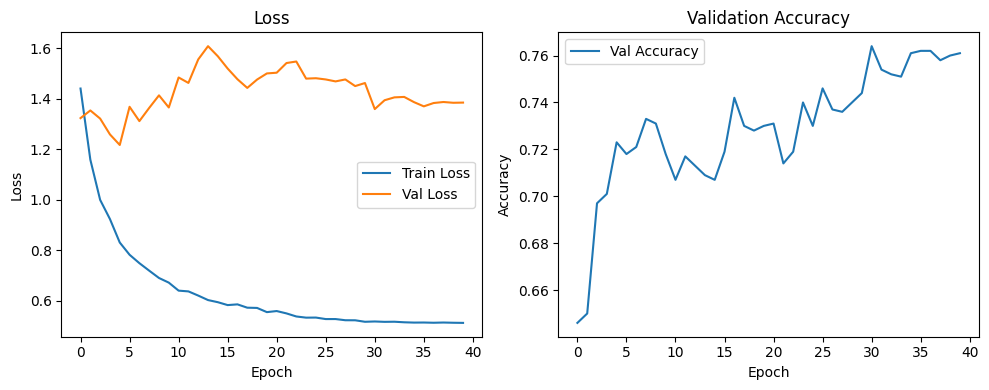

In [8]:
# === Plot Loss and Accuracy ===
train_losses = history["train_loss"]
train_acc = history["train_acc"]
val_losses = history["val_loss"]
val_acc = history["val_acc"]
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_acc, label='Val Accuracy')
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# 6. Confusion matrix

In [9]:
# style_map = {
#     0: "Abstract_Expressionism",
#     1: "Color_Field_Painting",
#     2: "Cubism",
#     3: "Early_Renaissance",
#     4: "High_Renaissance",
#     5: "Mannerism_Late_Renaissance",
#     6: "Minimalism",
#     7: "Naive_Art_Primitivism",
#     8: "Pop_Art",
#     9: "Rococo"
# }

# grab class names from your loader/dataset
def get_class_names_from_loader(loader):
    ds = loader.dataset
    if hasattr(ds, 'dataset') and hasattr(ds.dataset, 'classes'):
        return list(ds.dataset.classes)         # Subset(ImageFolder)
    if hasattr(ds, 'classes'):
        return list(ds.classes)                 # ImageFolder
    return [str(i) for i in range(getattr(ds, 'num_classes', 0))]

class_names = get_class_names_from_loader(test_loader)

# make a 10-class style_map that matches the dataset indices
style_map = {i: name for i, name in enumerate(class_names)}


print(style_map)


{0: 'Abstract_Expressionism', 1: 'Color_Field_Painting', 2: 'Cubism', 3: 'Early_Renaissance', 4: 'High_Renaissance', 5: 'Mannerism_Late_Renaissance', 6: 'Minimalism', 7: 'Naive_Art_Primitivism', 8: 'Pop_Art', 9: 'Rococo'}


In [10]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

labels_np = np.array([x.item() for x in all_labels])
preds_np = np.array([x.item() for x in all_preds])

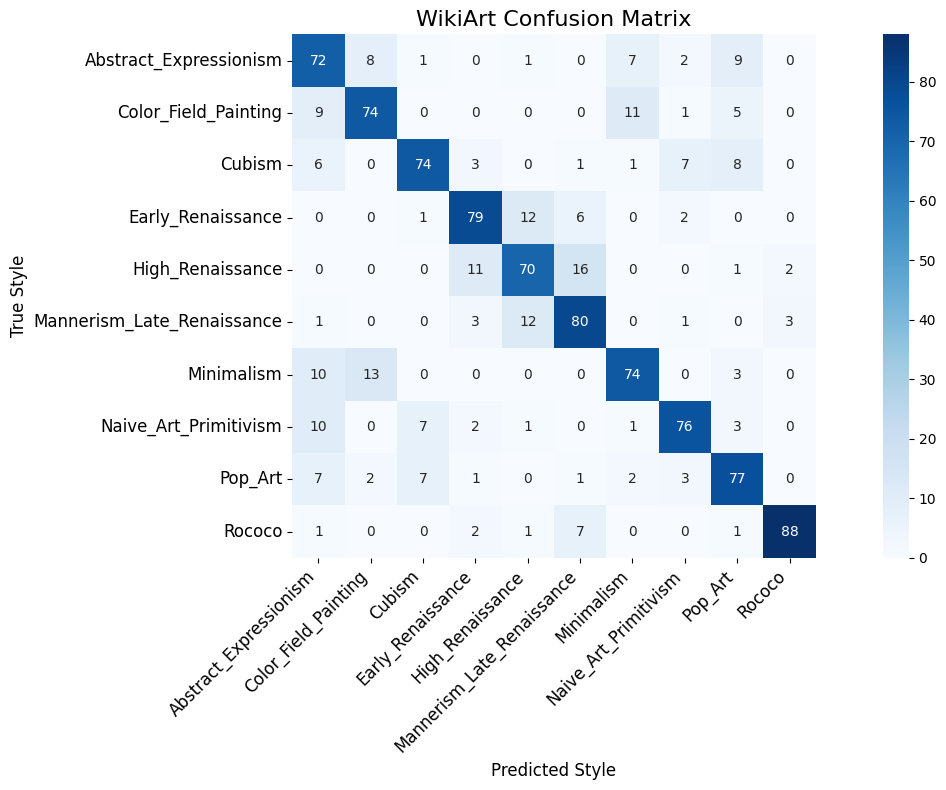

In [11]:
# === 1. Compute Confusion Matrix ===
cm = confusion_matrix(labels_np, preds_np)

# === 2. Get style names in label order ===
# Ensure the style_map is ordered by label index (0 to )
class_names = [style_map[i] for i in sorted(style_map.keys())]


# === 3. Plot ===
fig, ax = plt.subplots(figsize=(14, 8))
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                 xticklabels=class_names, yticklabels=class_names, square=True)

# Option 1: set the y ticklabels directly
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=12)

# (optional) x-axis too
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=12)

ax.set_title("WikiArt Confusion Matrix", fontsize=16)
ax.set_xlabel("Predicted Style", fontsize=12)
ax.set_ylabel("True Style", fontsize=12)
plt.tight_layout()
plt.show()

## Testing

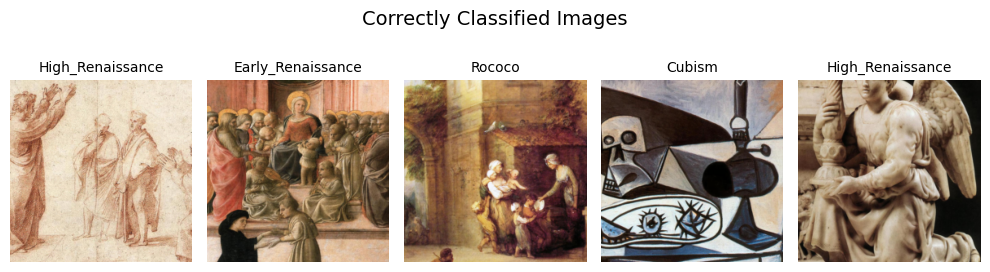

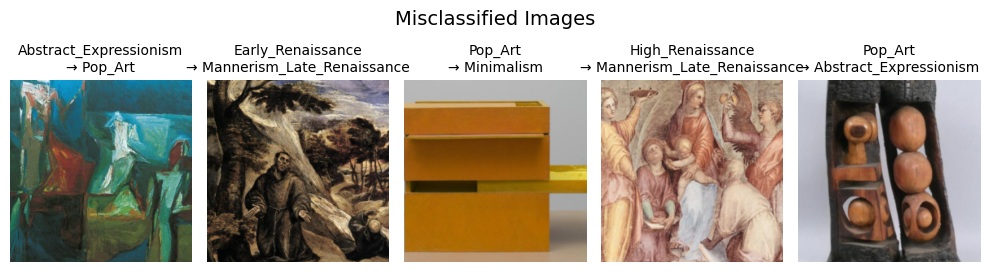

Test Accuracy: 0.7640 (764/1000)


In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


# === 1. Helper to Unnormalize and Convert to NumPy ===
def unnormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return (img_tensor * std + mean).clamp(0, 1)
# === 2. Collect All Images, Labels, Predictions ===
model.eval()
all_images = []
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_images.extend(images.cpu())
        all_preds.extend(preds.cpu())
        all_labels.extend(labels.cpu())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# === 3. Get Correct and Wrong Indices ===
correct_idx = np.where(all_preds == all_labels)[0]
wrong_idx = np.where(all_preds != all_labels)[0]

# === 4. Plotting Function ===
def show_images(indices, title="Samples", n=5):
    plt.figure(figsize=(10, 3))
    
    # Randomly sample from indices
    sampled_indices = np.random.choice(indices, size=min(n, len(indices)), replace=False)

    for i, idx in enumerate(sampled_indices):
        img = unnormalize(all_images[idx])  # Unnormalize
        img_np = img.permute(1, 2, 0).numpy()

        true_label = class_names[all_labels[idx]]
        pred_label = class_names[all_preds[idx]]
        is_correct = (true_label == pred_label)

        plt.subplot(1, n, i + 1)
        plt.imshow(img_np)
        plt.axis('off')
        if is_correct:
            plt.title(f"{true_label}", fontsize=10)
        else:
            plt.title(f"{pred_label}\n→ {true_label}", fontsize=10)
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# === 5. Show Some Correctly Classified Images ===
show_images(correct_idx, title="Correctly Classified Images", n=5)

# === 6. Show Some Misclassified Images ===
show_images(wrong_idx, title="Misclassified Images", n=5)

# === 7. Calculate Test Accuracy ===
correct = np.sum(all_preds == all_labels)
total = len(all_labels)
test_accuracy = correct / total

print(f"Test Accuracy: {test_accuracy:.4f} ({correct}/{total})")